# MLDA experiment in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

In [2]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")


GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
gpu_stream = cuda.Stream()

Utils

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import *

In [7]:
truth_path = "/home/florianb/havvarsel/multilevelDA/scripts/DataAssimilation/BasinTruth/2023-06-22T13_47_48"

## Case 

In [8]:
ls = [6, 7, 8, 9]

In [9]:
from utils.BasinParameters import * 

In [10]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [11]:
data_args_list = []
for l_idx in range(len(args_list)): 
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [12]:
Nes = [100, 50, 20, 5]

In [13]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsembleCase(Nes, args_list, data_args_list, sample_args, make_sim,
                            init_model_error_basis_args=init_model_error_basis_args, 
                            sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep)

from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

In [14]:
precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

### Data Assimilation

In [15]:
while MLOceanEnsemble.t < T_da:
    # Forward step
    MLOceanEnsemble.stepToObservation(MLOceanEnsemble.t + da_timestep)
    print(MLOceanEnsemble.t)

    # DA step
    true_eta, true_hu, true_hv = np.load(truth_path+"/truth_"+str(int(MLOceanEnsemble.t))+".npy")

    for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
        Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
        obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)
        
        prior = copy.deepcopy(MLOceanEnsemble.download())

        ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=0,
                                precomp_GC=precomp_GC[h])

900.0
1800.0
2700.0
3600.0
4500.0
5400.0
6300.0
7200.0
8100.0
9000.0
9900.0
10800.0
11700.0
12600.0
13500.0
14400.0
15300.0
16200.0
17100.0
18000.0
18900.0
19800.0
20700.0
21600.0


In [19]:
def plot_diagnostics():
    _, axs_truth = imshow3( np.load(truth_path+"/truth_"+str(int(MLOceanEnsemble.t))+".npy") )
    _, axs_mean  = imshow3(MLOceanEnsemble.estimate(np.mean))
    _, axs_var   = imshow3var(MLOceanEnsemble.estimate(np.var))


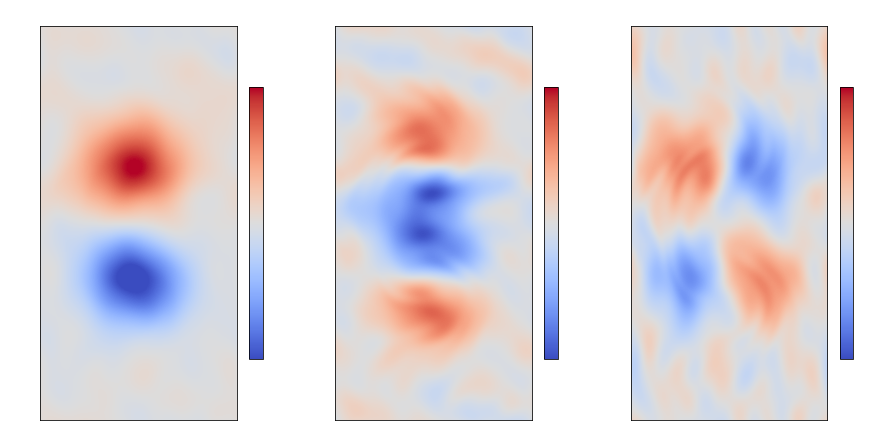

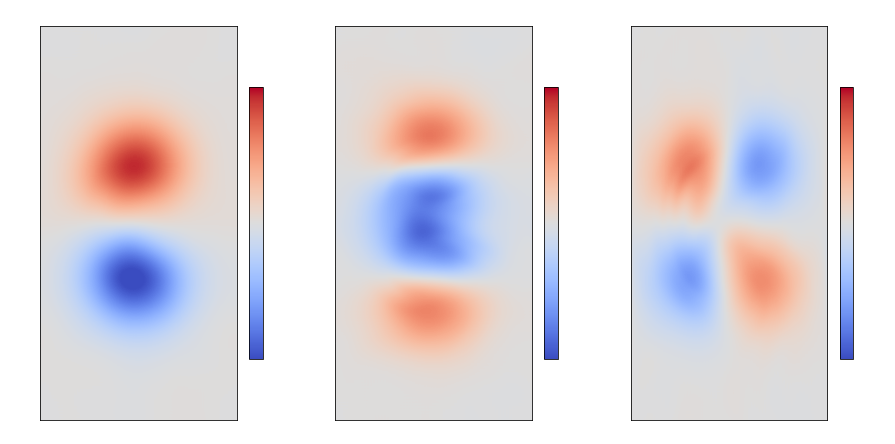

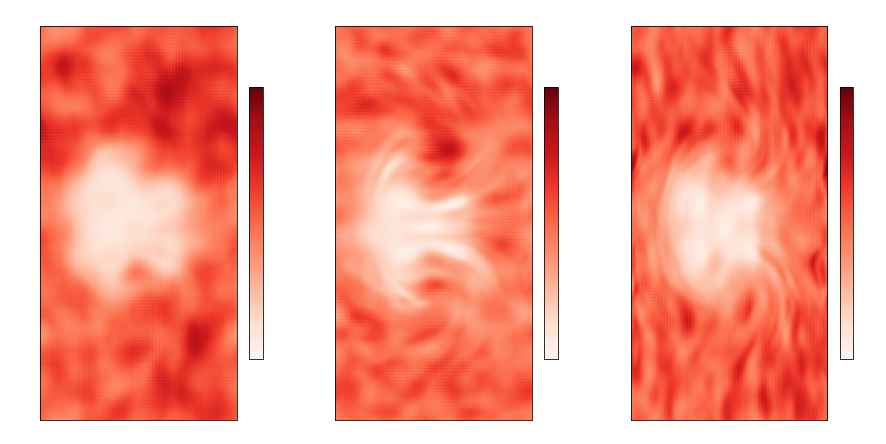

In [20]:
plot_diagnostics()

Different Kalman Gains

In [48]:
def plot_ML_K(ML_K):
    vlims = [0.005, 0.5, 0.5]

    fig, axs = plt.subplots(2, 3, figsize=(10,10))

    for i in range(2):
        
        ML_K_field = ML_K[:,i].reshape(3, args_list[-1]["ny"], args_list[-1]["nx"])
        
        for j in range(3):
            ax = axs[i,j]
            
            im = ax.imshow(ML_K_field[j,:,:], vmin=-vlims[j],vmax=vlims[j], cmap="coolwarm")
            ax.scatter(Hx, Hy, marker="x", c="black")
            plt.colorbar(im, ax=ax, shrink=0.5)

    fig.suptitle("Kalman Gain")

In [49]:
h = 0
obs_x, obs_y = obs_xs[h], obs_ys[h]
Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)

In [50]:
MLOceanEnsemble.upload(prior)

ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=0,
                                precomp_GC=precomp_GC[h])

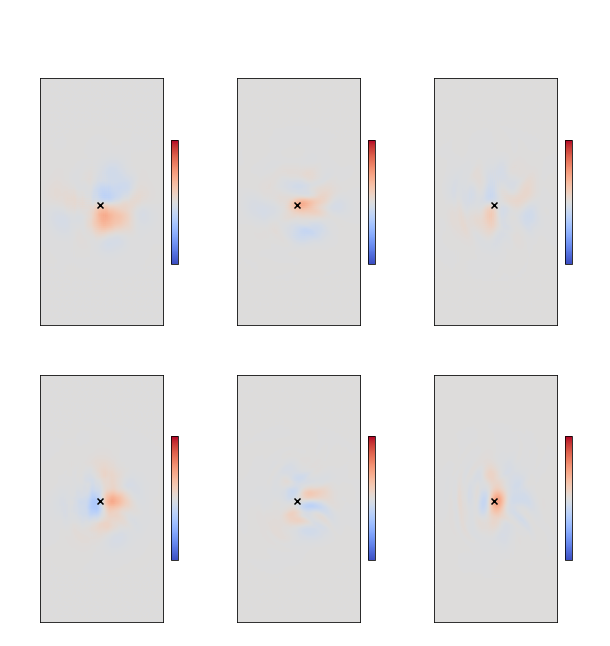

In [51]:
plot_ML_K(ML_K)

In [52]:
MLOceanEnsemble.upload(prior)

ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=1,
                                precomp_GC=precomp_GC[h])

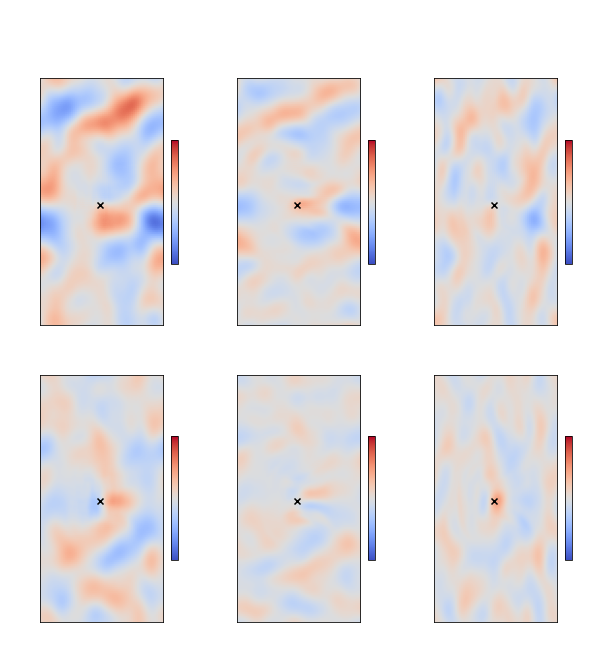

In [53]:
plot_ML_K(ML_K)

In [54]:
MLOceanEnsemble.upload(prior)

ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=10,
                                precomp_GC=precomp_GC[h])

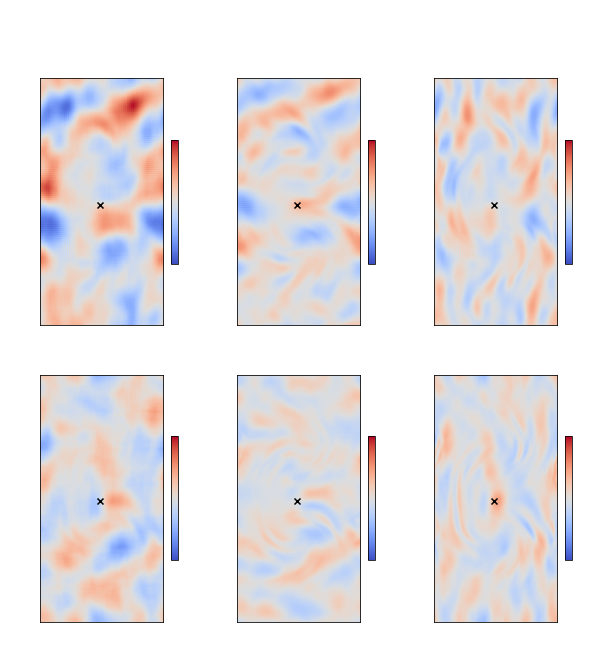

In [55]:
plot_ML_K(ML_K)